## TASK#3 AB test по линеризованным метрикам

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас) вида  𝑥𝑦  (У нас  clicks/likes).

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR\

При этом метод сам по себе очень прост. Что это за метрика такая?

- Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
- Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). 

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?\
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

Группы:
* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

In [1]:
import pandas as pd
import seaborn as sns
import pandahouse
import statsmodels as stats
import random
from scipy.stats import ttest_ind

In [73]:
#читаем нашу бд. нам нужны все 4 группы для этого теста

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM simulator_20230820.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#дф который мы выгрузили
df.head()

,exp_group,user_id,likes,views,ctr
0,1,18392,7,32,0.218750
1,3,115383,12,44,0.272727
2,3,123580,2,11,0.181818
3,2,131473,9,108,0.083333
4,4,107323,5,31,0.161290


In [60]:
# Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
# контрольные группы - 0 и 1

C0= df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()
C1= df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

C0, C1

(0.20983799195924746, 0.2096041628394293)

In [61]:
df['linearized_likes'] = 0

In [62]:
# Посчитаем ВО ВСЕХ группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 


df['linearized_likes'][df.exp_group == 0] = df['likes'][df.exp_group == 0] - C0 * df['views'][df.exp_group == 0]
df['linearized_likes'][df.exp_group == 3] = df['likes'][df.exp_group == 3] - C0 * df['views'][df.exp_group == 3]
df['linearized_likes'][df.exp_group == 1] = df['likes'][df.exp_group == 1] - C1 * df['views'][df.exp_group == 1]
df['linearized_likes'][df.exp_group == 2] = df['likes'][df.exp_group == 2] - C1 * df['views'][df.exp_group == 2]

df.head()

/tmp/ipykernel_193/1858722923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['linearized_likes'][df.exp_group == 0] = df['likes'][df.exp_group == 0] - C0 * df['views'][df.exp_group == 0]


,exp_group,user_id,likes,views,linearized_likes
0,1,18392,7,32,0.292667
1,3,115383,12,44,2.767128
2,3,123580,2,11,-0.308218
3,2,131473,9,108,-13.637250
4,4,107323,5,31,0.000000


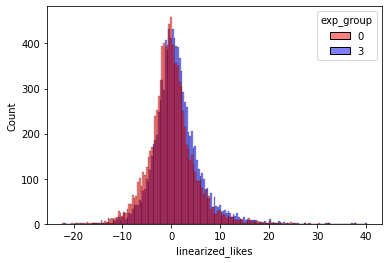

In [63]:
# смотрим группы 0 и 3
groups = sns.histplot(data = df[df.exp_group.isin((0,3))], 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [68]:
# t-test по группам 0 и 3
ttest03 = ttest_ind(df['linearized_likes'][df.exp_group == 0], df['linearized_likes'][df.exp_group == 3], 
                    equal_var = False)
ttest03

Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

In [75]:
# и смотрим какой p-value по CTR
ttest03_2 = ttest_ind(df['ctr'][df.exp_group == 0], df['ctr'][df.exp_group == 3], 
                    equal_var = False)
ttest03_2

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

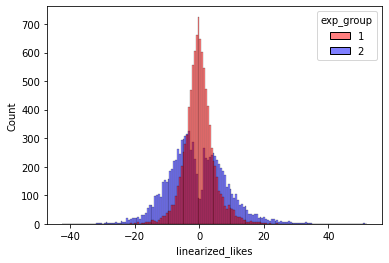

In [66]:
# смотрим группы 1 и 2
groups = sns.histplot(data = df[df.exp_group.isin((1,2))], 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [69]:
# t-test по группам 1 и 2
ttest12 = ttest_ind(df['linearized_likes'][df.exp_group == 1], df['linearized_likes'][df.exp_group == 2],
                   equal_var = False)
ttest12

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

### Вывод 
p-value больше 0.05 в обеих экспериментах.

 - В первом эксперименте - P-value стал меньше
 - Во втором эксперименте - тоже стал меньше (p-value по Манна-Уитни был pvalue=4.632205841806026e-45, не уверена что так корректно сравнивать)